In [1]:
%pip install mne xgboost tensorflow scikit-learn pandas numpy matplotlib scipy tqdm


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report, cohen_kappa_score)
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tqdm import tqdm
import warnings
from scipy import signal
warnings.filterwarnings('ignore')

In [3]:
def load_emotion_data(data_dir):                                                        # Emotion icin veri setini yukluyoruz.
    file_pairs = []
    
    for f in os.listdir(data_dir):                                                      # Dosya eslestirme islemi yapiyoruz.
        if f.endswith('.set'):
            events_file = f.replace('_eeg.set', '_events.tsv')                          # Set dosyasi ham sinyalleri tutar, tsv dosyasi eventleri tutar.
            events_path = os.path.join(data_dir, events_file)
            if os.path.exists(events_path):
                file_pairs.append((
                    os.path.join(data_dir, f),
                    events_path
                ))
            else:
                print(f"Event dosyası bulunamadı: {events_path}")
    
    print(f"Bulunan EEG-Event çiftleri: {len(file_pairs)}")
    for pair in file_pairs:
        print(f"  {pair[0]} - {pair[1]}")
    return file_pairs


In [4]:
from scipy.signal import find_peaks, welch
from scipy.stats import entropy, kurtosis, skew, iqr

def extract_emotion_features(data, sfreq):
    feature_list = []
    count = 0
    
    # Zaman serisinde ozellik cikarimi yapiyorum. Buradaki ozniteliklerin cogunu TSFEL: Time Series Feature Extraction Library makalesinden aldim.

    for epoch in data:
        feats = []
        for ch_signal in epoch:
            t = np.arange(len(ch_signal))
            abs_energy = np.sum(ch_signal**2)                                                           # Sinyalin toplam enerjisi, guc olcusu
            area_curve = np.trapz(ch_signal)                                                            # Egri alti alan, sinyalin integraline benzer toplam degeri
            
            autocorr = np.corrcoef(ch_signal[:-1], ch_signal[1:])[0, 1] if np.std(ch_signal) > 0 else 0 # Sinyalin kendisiyle bir gecikmeyle olan korelasyonu
            
            avg_power = np.mean(ch_signal**2)                                                           # Ortalama guc
            centroid = np.sum(t * np.abs(ch_signal)) / (np.sum(np.abs(ch_signal)) + 1e-12)              # Sinyal agirlik merkezi
            
            hist, _ = np.histogram(ch_signal, bins=10, density=True)
            hist_entropy = entropy(hist + 1e-12)                                                        # Sinyal genlik dagiliminin duzensizligi
            
            freqs, psd = welch(ch_signal, sfreq, nperseg=min(256, len(ch_signal)))
            psd /= np.sum(psd) + 1e-12                                                                  # Frekanslara gore enerji dagilimi
            
            fund_freq = freqs[np.argmax(psd)] if len(psd) > 0 else 0                                    # En yuksek guce sahip frekans bileşeni
            
            hist_vals, hist_bins = np.histogram(ch_signal, bins=10)
            hist_mode = hist_bins[np.argmax(hist_vals)]                                                 # En cok gorulen genlik degeri
            
            human_energy = np.sum(psd[(freqs >= 0.5) & (freqs <= 40)])                                  # Insan EEG bandindaki enerji
            iqr_val = iqr(ch_signal)                                                                    # Sinyalin orta %50'sinin yayilimi
            kurt_val = kurtosis(ch_signal)                                                              # Carpiklik, uc deger yogunlugu
            
            max_val = np.max(ch_signal)                                                                 # Maksimum deger
            max_psd = np.max(psd)                                                                       # Maksimum guc
            max_freq = freqs[-1]                                                                         # En yuksek olculebilir frekans
            
            mean_val = np.mean(ch_signal)                                                               # Ortalama deger
            mad = np.mean(np.abs(ch_signal - mean_val))                                                 # Ortalama mutlak sapma
            mean_abs_diff = np.mean(np.abs(np.diff(ch_signal)))                                         # Komşu ornekler arasindaki ortalama mutlak fark
            mean_diff = np.mean(np.diff(ch_signal))                                                     # Komşu ornekler arasindaki ortalama fark
            
            med_val = np.median(ch_signal)                                                              # Medyan deger
            med_abs_dev = np.median(np.abs(ch_signal - med_val))                                        # Medyan mutlak sapma
            med_abs_diff = np.median(np.abs(np.diff(ch_signal)))                                        # Medyan komşu mutlak farki
            med_diff = np.median(np.diff(ch_signal))                                                    # Medyan komşu farki
            cumulative_power = np.cumsum(psd)
            med_freq = freqs[np.argmax(cumulative_power >= 0.5)] if len(psd) > 0 else 0                 # Medyan frekans
            
            min_val = np.min(ch_signal)                                                                 # Minimum deger
            
            diff_signal = np.diff(ch_signal)
            sign_changes = np.diff(np.sign(diff_signal))
            neg_turning = np.sum(sign_changes > 0)                                                      # Negatif egimden pozitif egime geciş sayisi
            pos_turning = np.sum(sign_changes < 0)                                                      # Pozitif egimden negatif egime geciş sayisi
            peaks, _ = find_peaks(ch_signal)
            n_peaks = len(peaks)                                                                        # Tepe sayisi
            peak_dist = np.mean(np.diff(peaks)) if n_peaks > 1 else 0                                   # Tepeler arasi ortalama mesafe
            
            if len(psd) > 0:
                peak_psd = np.max(psd)
                mask = psd >= (peak_psd / 2)
                try:
                    power_bandwidth = freqs[mask][-1] - freqs[mask][0]                                  # Gucun %50'sinden fazlasini iceren frekans araligi
                except:
                    power_bandwidth = 0
            else:
                power_bandwidth = 0
                
            rms = np.sqrt(avg_power)                                                                    
            signal_dist = np.sum(np.abs(ch_signal))                                                     # Mutlak genlik toplami
            skew_val = skew(ch_signal)                                                                  # Simetri olcusu
            slope = np.polyfit(t, ch_signal, 1)[0]                                                      # Lineer egim, trend
            
            spec_centroid = np.sum(freqs * psd) / (np.sum(psd) + 1e-12)                                 # Spektral agirlik merkezi
            spec_decrease = np.sum((psd[1:] - psd[0]) / np.arange(1, len(psd))) / (np.sum(psd[1:]) + 1e-12) if len(psd) > 1 else 0   # Yuksek frekanslardaki guc kaybi
            spec_ent = entropy(psd + 1e-12)                                                             # Spektral entropi
            spec_kurt = kurtosis(psd)                                                                   # Spektral carpiklik
            diff_psd = np.diff(psd)
            psd_sign_changes = np.diff(np.sign(diff_psd))
            spec_pos_turning = np.sum(psd_sign_changes < 0)                                             # Spektral donuş noktasi sayisi
            spec_roll_off = freqs[np.argmax(cumulative_power >= 0.85)] if len(psd) > 0 else 0           # Enerjinin %85'ine ulaşilan frekans
            spec_roll_on = freqs[np.argmax(cumulative_power >= 0.05)] if len(psd) > 0 else 0            # Enerjinin %5'ine ulaşilan frekans
            spec_skew = skew(psd)                                                                       # Spektral skewness
            spec_slope = np.polyfit(freqs, psd, 1)[0] if len(psd) > 1 else 0                            # Spektral egim
            spec_spread = np.sqrt(np.sum(psd * (freqs - spec_centroid)**2) / (np.sum(psd) + 1e-12))     # Spektral yayilma
            
            std = np.std(ch_signal)                                                                     # Standart sapma
            sum_abs_diff = np.sum(np.abs(np.diff(ch_signal)))                                           # Ornekler arasi toplam fark
            var = np.var(ch_signal)                                                                     # Varyans
            
            zero_crossings = np.sum(np.diff(np.sign(ch_signal)) != 0)
            zcr = zero_crossings / len(ch_signal)                                                       # Sinyalin kac kez sifiri gectigi
            
            features = [
                abs_energy, area_curve, autocorr, avg_power, centroid, hist_entropy,
                fund_freq, hist_mode, human_energy, iqr_val, kurt_val, max_val,
                max_psd, max_freq, mean_val, mad, mean_abs_diff, mean_diff, med_val,
                med_abs_dev, med_abs_diff, med_diff, med_freq, min_val, neg_turning,
                n_peaks, peak_dist, pos_turning, power_bandwidth, rms, signal_dist,
                skew_val, slope, spec_centroid, spec_decrease, spec_ent,
                spec_kurt, spec_pos_turning, spec_roll_off, spec_roll_on, spec_skew,
                spec_slope, spec_spread, std, sum_abs_diff, var, zcr
            ]
            
            feats.extend(features)
            
        feature_list.append(feats)
        count += 1
        
    print(f"ozellik cikarimi icin toplam {count} epoch işlendi.")
    return np.array(feature_list)

In [5]:
"""label_mapping = {
    'ibeg': 0, 'iend': 1, 'rsrt': 2, 'fixl': 3,
    'quiz': 4, 'qdon': 5, 'base': 6, 'bend': 7, 'trno': 8,
    'fixL': 9, 'stm': 10, 'clic': 11, 'vlnc': 12, 'arsl': 13,
    'dmns': 14, 'lkng': 15, 'fmrt': 16, 'relv': 17, 'cate': 18,
    'IBEG': 19, 'IEND': 20, 'puse': 21, 'boundary': 22, 'stop': 23,
    'baseline': 24,'baseend': 25,'trialno': 26,'fixation loop': 27,
    'neutral_1_1': 28,'valence': 29,'arousal': 30,'dominance': 31,'liking': 32,
    'familiarity': 33,'relevance': 34,'3_2': 35,'click': 36,
    'impedances begin': 37,'emotion_categ': 38,'impedances end': 39,'stop event': 40
}"""
label_mapping = {                                                                               # Bazilari digerlerinin kucuk harfle yazilmis hali, onlari birlestirdim.
    'ibeg': 0, 'iend': 1, 'rsrt': 2, 'fixl': 3,
    'quiz': 4, 'qdon': 5, 'base': 6, 'bend': 7, 'trno': 8,
    'fixL': 9, 'stm': 10, 'clic': 11, 'vlnc': 12, 'arsl': 13,
    'dmns': 14, 'lkng': 15, 'fmrt': 16, 'relv': 17, 'cate': 18,
    'IBEG': 0, 'IEND': 1, 'puse': 19, 'boundary': 20, 'stop': 21,
    'baseline': 22,'baseend': 23,'trialno': 24,'fixation loop': 25,
    'neutral_1_1': 26,'valence': 27,'arousal': 13,'dominance': 14,'liking': 15,
    'familiarity': 16,'relevance': 17,'3_2': 28,'click': 29,
    'impedances begin': 30,'emotion_categ': 31,'impedances end': 32,'stop event': 33
}
def create_emotion_dataset(file_pairs, epoch_duration=2.0):
    X_list, y_list = [], []
    for eeg_file, event_file in file_pairs:
        print(f"\nİşleniyor: {os.path.basename(eeg_file)}")
        print(f"Olay dosyası: {os.path.basename(event_file)}")
        
        try:
            
            print("  EEG verisi yükleniyor...")                                                 # EEG verisini yukluyoruz.
            raw = mne.io.read_raw_eeglab(eeg_file, preload=True, verbose=False)
            print(f"  EEG verisi yüklendi: {len(raw.ch_names)} kanal, {raw.n_times} örnek")
            

            print("  Olay dosyası okunuyor...")                                                 # Olay etiketlerini yukluyoruz.
            events_df = pd.read_csv(event_file, sep='\t')
            print(f"  Olay dosyası yüklendi: {len(events_df)} olay")
            print("  Örnek olaylar:")
            print(events_df.head())
            
            print("Event onset sütunu örnekleri:")
            print(events_df["onset"].head(10))
            print("EEG sfreq:", raw.info["sfreq"])
            print("EEG örnek sayısı:", len(raw))


            events = []
            for _, row in events_df.iterrows():                                                  # Etiketleri sayisallastiriyorum.

                sample = int(row['onset'] * raw.info['sfreq'] / 1000)                            # Milisaniye cinsinden oldugu icin 1000'e boldum.
                label_str = str(row['trial_type']).lower().strip()
                label = label_mapping.get(label_str, -1)
                if label >= 0:
                    events.append([sample, 0, label])                                            # Gecerli sayisal etiketi ekliyoruz.
                else:
                    print(f"    UYARI: Bilinmeyen etiket '{label_str}' - atlandı")
            
            if not events:
                print("  HATA: Hiç geçerli olay bulunamadı!")
                continue
            
            raw_length = len(raw)
            for e in events:                                                                     # Olaylarin EEG kaydi icinde olup olmadigini kontrol ediyorum.
                onset = e[0]
                if onset < 0 or onset >= raw_length:
                    print(f"Olay {onset} EEG kaydının dışında!")

            max_sample = raw.n_times - int(epoch_duration * raw.info['sfreq'])
            print(f"  {len(events)} geçerli olay bulundu")
            
            if not events:
                print("  HATA: Filtrelemeden sonra hiç geçerli olay bulunamadı!")
                continue
                
            events_array = np.array(events, dtype=np.int64)                                     # Olaylari integer array'e ceviriyorum.
            print(f"  {len(events_array)} geçerli olay bulundu")
            
            print("  Epoch'lar oluşturuluyor...")                                               # Epochlari olusturuyorum.
            epochs = mne.Epochs(
                raw, 
                events_array, 
                tmin=0.0, 
                tmax=epoch_duration,
                baseline=None,
                preload=True,
                reject_by_annotation=False,
                on_missing='warn',                                                              # Tekrarlama ile ilgili hata aliyordum o yuzden ChatCPT merge parametresini onerdi ve duzeldi.
                event_repeated='merge'
            )
            
            print(f"  {len(epochs)} epoch oluşturuldu")
            
            if len(epochs) == 0:
                print("  HATA: Hiç epoch oluşturulamadı!")
                continue
                

            data = epochs.get_data()                                                            # Epoch verilerini aliyorum.
            print(f"  Epoch veri boyutu: {data.shape} (epoch x kanal x zaman)")
            
            print("  Özellikler çıkarılıyor...")
            feats = extract_emotion_features(data, raw.info['sfreq'])                           # Ozelliklerini cikartiyorum.
            print(f"  Özellikler çıkarıldı: {feats.shape} (epoch x özellik)")
            
            X_list.append(feats)
            y_list.append(epochs.events[:, -1])
            
        except Exception as e:
            print(f"  HATA: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    if X_list:                                                                                  # Tum verileri birlestiriyorum
        X = np.vstack(X_list)
        y = np.hstack(y_list)
        print(f"\nToplam {len(X)} epoch işlendi")
        print(f"Sınıf dağılımı: {pd.Series(y).value_counts()}")
        return X, y
    else:
        print("\nUYARI: Hiç veri işlenemedi!")
        return np.array([]), np.array([])

In [6]:
def evaluate_model(y_true, y_pred, name):                                                                           # Temel metrikleri hesapliyorum
    acc = accuracy_score(y_true, y_pred)                                                                            # Isabet
    f1 = f1_score(y_true, y_pred, average='macro')                                                                  # f1 skoru
    kappa = cohen_kappa_score(y_true, y_pred)                                                                       # Cohen Kappa skoru
        
    print(f"\n{name} Performans:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print("Sınıflandırma Raporu:")
    
    unique_labels = np.unique(y_true)                                                                               # Coklu label isminden dolayi hata aliyordum burayi ekledim.
    unique_names = [list(label_mapping.keys())[list(label_mapping.values()).index(l)] for l in unique_labels]

    print("Sınıflandırma Raporu:")
    print(classification_report(y_true, y_pred, labels=unique_labels, target_names=unique_names))

        
    cm = confusion_matrix(y_true, y_pred)                                                                           # Confusion matrix gosteriyorum.
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    plt.ylabel('Gerçek')
    plt.xlabel('Tahmin')
    plt.show()
        
    return acc, f1, kappa
    

def train_rf_model(X_train, y_train, X_test, y_test):                                                               # Random Forest modeli kullaniyorum.
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)                                                                                        # Modeli egitip test yapiyorum
    rf_pred = rf.predict(X_test)

    rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")                                                   # Modelin sonucunu kaydediyorum.
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(rf.feature_importances_)), rf.feature_importances_)
    plt.title('Random Forest - Özellik Önemleri')
    plt.xlabel('Önem Skoru')
    plt.tight_layout()
    plt.show()

    return rf,rf_metrics


def train_xgb_model(X_train, y_train, X_test, y_test):                                                              # XGB modeli kullaniyorum.
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    xgb_model.fit(X_train, y_train)                                                                                 # Model egitimi ve tahmini.
    xgb_pred = xgb_model.predict(X_test)

    xgb_metrics = evaluate_model(y_test, xgb_pred, "XGBoost")
    

    return xgb_model,xgb_metrics

def train_mlp_model(X_train, y_train, X_test, y_test):                                                              # Bir MLP modeli egitiyorum.

    model = Sequential([                                                                                            # 3 gizli katman ve Dropout ile tanimladim.
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(len(label_mapping), activation='softmax')
    ])
    
    model.compile(                                                                                                  # Modeli derliyorum.
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    early_stop = tf.keras.callbacks.EarlyStopping(                                                                  # Early stopping ile dogrulama kaybi degismezse 5 epoch sonra egitimi durduruyorum.
        monitor='val_loss', 
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(                                                                                            # Modeli egitiyorum.
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )
    
    mlp_pred = np.argmax(model.predict(X_test), axis=1)                                                             # Model sonuclarini aliyoruz ve grafigini cikartiyoruz.
    mlp_metrics = evaluate_model(y_test, mlp_pred, "MLP")
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.title('Model Doğruluğu')
    plt.ylabel('Doğruluk')
    plt.xlabel('Epok')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Model Kaybı')
    plt.ylabel('Kayıp')
    plt.xlabel('Epok')
    plt.legend()
    plt.show()
    
    return model, mlp_metrics


In [7]:
def my_standard_scaler(X):              # Verilerimi 0-1 arasina standartize ediyorum.
    mean = np.mean(X, axis=0)           # Her sutunun ortalamasi
    std = np.std(X, axis=0)             # Her sutunun standart sapmasi
    X_scaled = (X - mean) / std         # Standardizasyon formulu
    return X_scaled

Bulunan EEG-Event çiftleri: 3
  ./EmotionData/Emotion_EDF_Training_Data\sub-mit096_task-Emotion_eeg.set - ./EmotionData/Emotion_EDF_Training_Data\sub-mit096_task-Emotion_events.tsv
  ./EmotionData/Emotion_EDF_Training_Data\sub-mit097_task-Emotion_eeg.set - ./EmotionData/Emotion_EDF_Training_Data\sub-mit097_task-Emotion_events.tsv
  ./EmotionData/Emotion_EDF_Training_Data\sub-mit104_task-Emotion_eeg.set - ./EmotionData/Emotion_EDF_Training_Data\sub-mit104_task-Emotion_events.tsv
Found 3 (raw, annots) pairs:
   ./EmotionData/Emotion_EDF_Training_Data\sub-mit096_task-Emotion_eeg.set ./EmotionData/Emotion_EDF_Training_Data\sub-mit096_task-Emotion_events.tsv
   ./EmotionData/Emotion_EDF_Training_Data\sub-mit097_task-Emotion_eeg.set ./EmotionData/Emotion_EDF_Training_Data\sub-mit097_task-Emotion_events.tsv
   ./EmotionData/Emotion_EDF_Training_Data\sub-mit104_task-Emotion_eeg.set ./EmotionData/Emotion_EDF_Training_Data\sub-mit104_task-Emotion_events.tsv

İşleniyor: sub-mit096_task-Emotion_ee

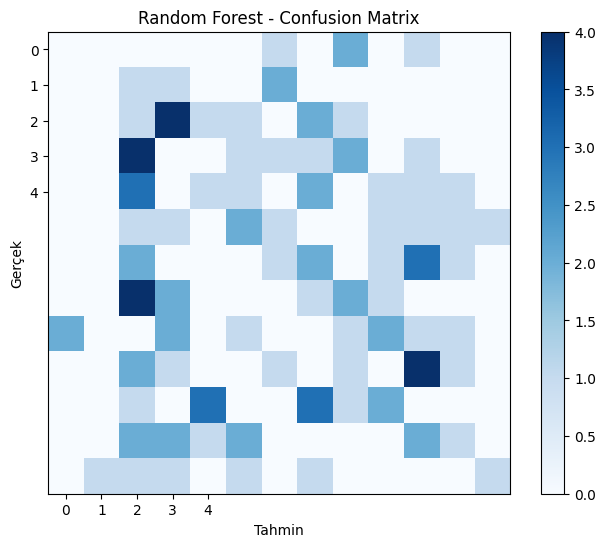

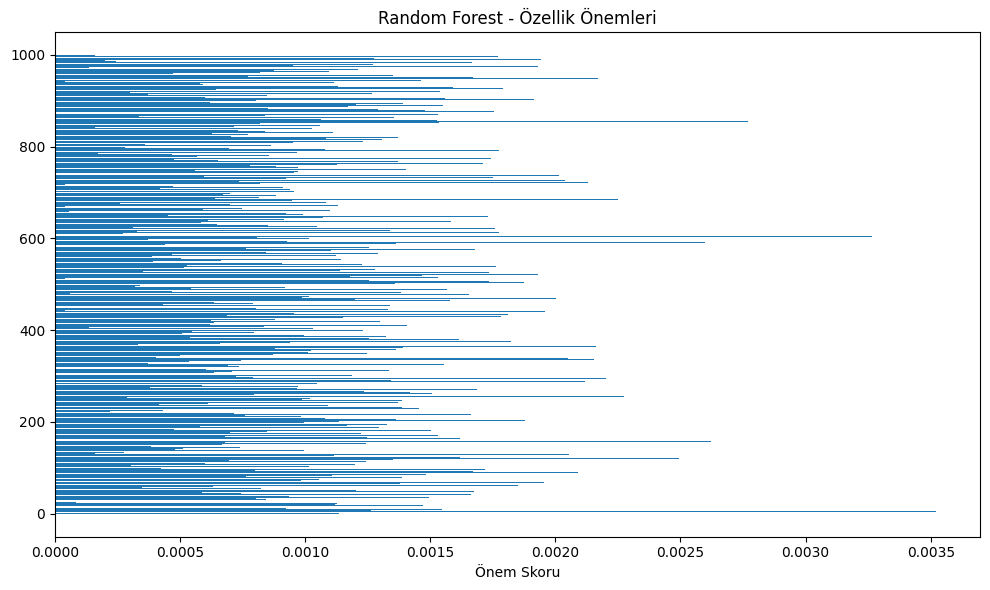


XGBoost Performans:
Accuracy: 0.0531
Macro F1: 0.0509
Cohen's Kappa: -0.0348
Sınıflandırma Raporu:
Sınıflandırma Raporu:
              precision    recall  f1-score   support

        ibeg       0.00      0.00      0.00         4
        iend       0.00      0.00      0.00         4
        rsrt       0.00      0.00      0.00        10
        fixl       0.00      0.00      0.00        10
        quiz       0.25      0.20      0.22        10
        qdon       0.00      0.00      0.00         9
        base       0.00      0.00      0.00        10
        bend       0.08      0.10      0.09        10
        trno       0.07      0.10      0.08        10
        fixL       0.00      0.00      0.00        10
         stm       0.00      0.00      0.00        10
        clic       0.07      0.10      0.08        10
        vlnc       0.20      0.17      0.18         6

    accuracy                           0.05       113
   macro avg       0.05      0.05      0.05       113
weighted avg

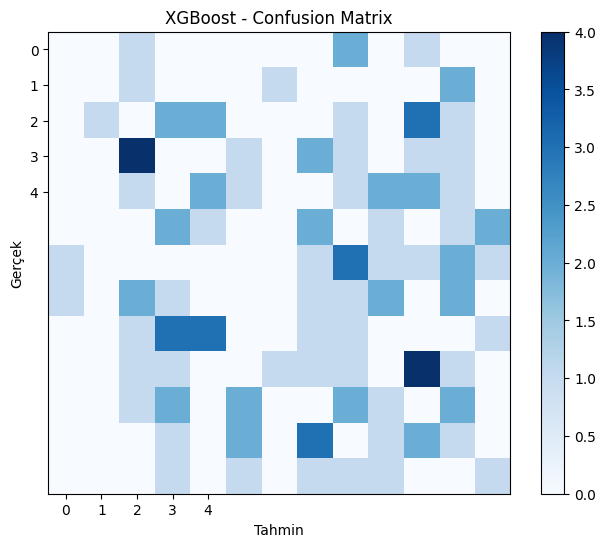

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.0224 - loss: 3.9569 - val_accuracy: 0.0566 - val_loss: 3.5104
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0597 - loss: 3.5463 - val_accuracy: 0.0000e+00 - val_loss: 3.3200
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0699 - loss: 3.4853 - val_accuracy: 0.0566 - val_loss: 3.1760
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1124 - loss: 3.1209 - val_accuracy: 0.0943 - val_loss: 3.1062
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1155 - loss: 3.0220 - val_accuracy: 0.0943 - val_loss: 3.0484
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1323 - loss: 2.8911 - val_accuracy: 0.1132 - val_loss: 2.9611
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1764 - loss: 2.8238 - val_accuracy: 0.0755 - val_loss: 2.9244
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1261 - loss: 2.8580 - val_accuracy: 0.0377 - val_loss: 2.9

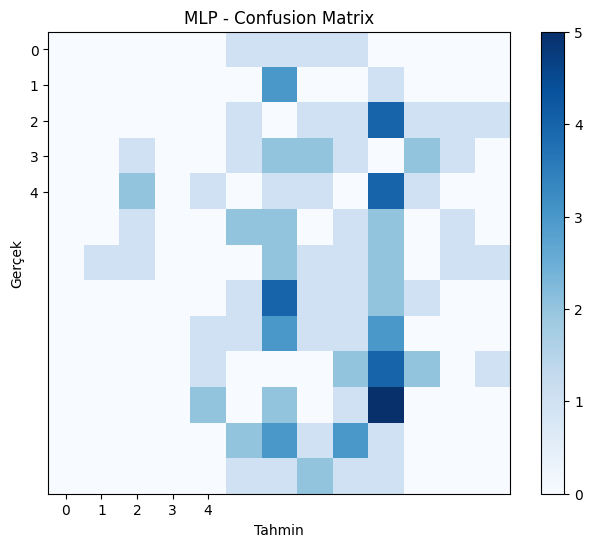

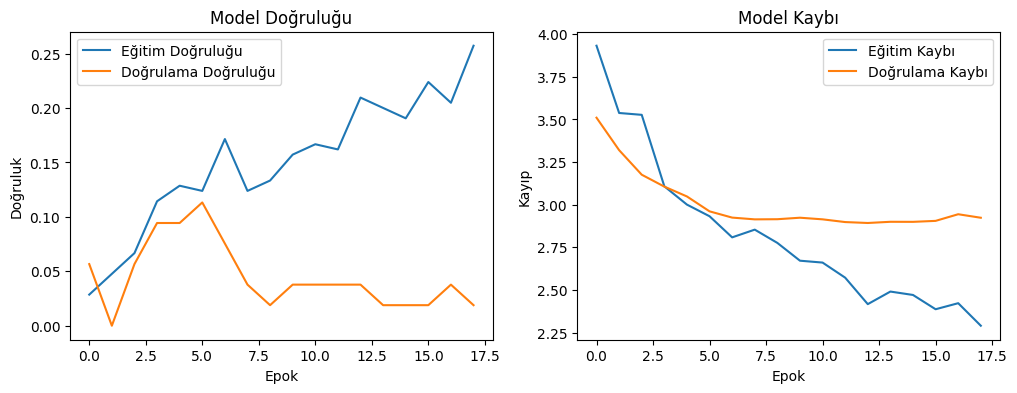


MODEL PERFORMANS KARŞILAŞTIRMASI:
RF: Accuracy=0.07964601769911504, F1=0.08409833630421867, Kappa=-0.006681514476614581
XGB: Accuracy=0.05309734513274336, F1=0.05089355089355089, Kappa=-0.03483396097226965
MLP: Accuracy=0.09734513274336283, F1=0.06501587243430539, Kappa=0.012085368989457446
Modeller başarıyla kaydedildi!


In [8]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

def main():

    DATA_DIR = "./EmotionData/Emotion_EDF_Training_Data"                                            # Egitim verisinin oldugu yer.
    
    file_pairs = load_emotion_data(DATA_DIR)                                                        # Duygu verisini okuyoruz.
    print(f"Found {len(file_pairs)} (raw, annots) pairs:")
    for raw_path, annot_path in file_pairs:
        print("  ", raw_path, annot_path)
    X, y = create_emotion_dataset(file_pairs, epoch_duration=2.0)                                   # Modelin verisetini cikartiyoruz.
    
    print(f"Oluşturulan veri seti boyutu: {X.shape}")
    print(f"Sınıf dağılımı: {pd.Series(y).value_counts()}")

    counts = pd.Series(y).value_counts()                                                            # Nadir classlari cikarmam gerekti cunku egitimde hata veriyordu.
    valid_classes = counts[counts > 10].index
    mask = np.isin(y, valid_classes)
    X_filtered = X[mask]
    y_filtered = y[mask]

    X_filtered = my_standard_scaler(X_filtered)                                                     # Veriyi olceklendiriyoruz.

    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X_filtered)
    
    k = 1000                                                                                        # 132*47 ozellik arasindan en anlamli ozellikleri secmek istiyorum
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X_imputed, y_filtered)
    selected_indices = selector.get_support(indices=True)
    print(f"Seçilen feature indeksleri: {selected_indices}")
    print("Özellik (feature) sayısı:", X_selected.shape[1])
    print(f"Başlangıçta toplam özellik sayısı: {X.shape[1]}")

    X_train, X_test, y_train, y_test = train_test_split(                                            # Egitim ve test verisini ayiriyoruz.
        X_selected, y_filtered, test_size=0.3, random_state=42, stratify=y_filtered
    )

    train_classes = np.unique(y_train)                                                              # Sadece train'de olan class'lar testte kalsin dedim cunku yine hata aliyordum.
    test_mask = np.isin(y_test, train_classes)
    X_test = X_test[test_mask]
    y_test = y_test[test_mask]

    from sklearn.preprocessing import LabelEncoder                                                  # Labellari yeniden indeksledim.
    le = LabelEncoder()
    all_labels = np.concatenate([y_train, y_test])
    le.fit(all_labels)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)

    rf_model,rf_results = train_rf_model(X_train, y_train_enc, X_test, y_test_enc)                  # Modelleri egitiyorum ve degerlendiriyorum.
    xgb_model,xgb_results = train_xgb_model(X_train, y_train_enc, X_test, y_test_enc)
    mlp_model,mlp_results = train_mlp_model(X_train, y_train_enc, X_test, y_test_enc)

    rf_acc, rf_f1, rf_kappa = rf_results
    xgb_acc, xgb_f1, xgb_kappa = xgb_results
    mlp_acc, mlp_f1, mlp_kappa = mlp_results
    print("\nMODEL PERFORMANS KARŞILAŞTIRMASI:")                                                    # En sonda toplu performans karsilastirmasi yapiyorum.
    print(f"RF: Accuracy={rf_acc}, F1={rf_f1}, Kappa={rf_kappa}")
    print(f"XGB: Accuracy={xgb_acc}, F1={xgb_f1}, Kappa={xgb_kappa}")
    print(f"MLP: Accuracy={mlp_acc}, F1={mlp_f1}, Kappa={mlp_kappa}")


    import joblib                                                                                   # Egittigimiz modelleri kaydediyorum.
    from tensorflow.keras.models import save_model
    
    joblib.dump(imputer, 'imputer.joblib')     # İmpüteri kaydediyoruz
    joblib.dump(selector, 'selector.joblib')   # Selector'u da kaydediyoruz
    joblib.dump(rf_model, 'random_forest_model.joblib')
    joblib.dump(xgb_model, 'xgboost_model.joblib')
    

    mlp_model.save('mlp_model.h5')
    
    joblib.dump(le, 'label_encoder.joblib')
    print("Modeller başarıyla kaydedildi!")

if __name__ == "__main__":
    main()